### **VGG-1**

This notebook is for our first transfer learning model using VGG16. Pre-processing consists of samplewise centering and samplewise standard normalization only.

Optimizer: ADAM

Batch size: 64

Image size: 64 x 64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# To retrieve files/pathnames matching a specified pattern
import glob

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/MMAI/894/team_project/ASL_Dataset/Train'
TEST_DIR = '/content/drive/MyDrive/MMAI/894/team_project/ASL_Dataset/Test'

In [ ]:
# Load all the images under each class (subdirectory)
def load_images(base_dir, directories_as_labels=True, files='**/*.jpg'):
  filenames = glob.glob(os.path.join(base_dir, files))

  # Load all the subdirectories as classes
  classes = (os.path.basename(os.path.dirname(name)) for name in filenames)
  df = pd.DataFrame(list(zip(filenames, classes)), columns=['path', 'label'])

  return df

train_df = load_images(TRAIN_DIR)
test_df = load_images(TEST_DIR)

In [ ]:
batch_size = 64
image_size = 64
num_class = len(train_df['label'].unique())

In [ ]:
# X_training data from a directory
# Sub-directory in that directory will be used as a class for each object
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   horizontal_flip=False)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        subset = 'training',
                        shuffle=True)

Found 116101 images belonging to 28 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        subset = 'validation',
                        shuffle=True)

Found 49728 images belonging to 28 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

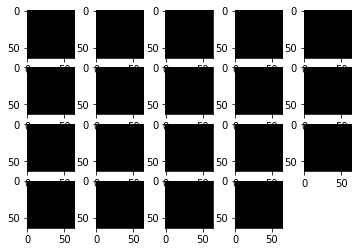

In [ ]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 5
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

### Creating Model from VGG16

**Network Model: VGG16 model architecture**

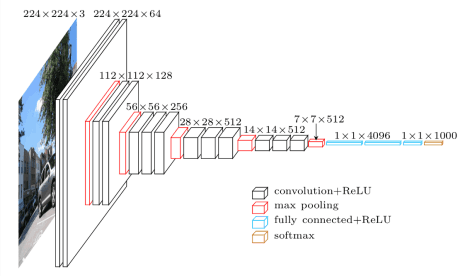

In [ ]:
import keras
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
# Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# Freeze the layers 
base_model.trainable = False

# Create the model
model = keras.models.Sequential()
# Add the vgg convolutional base model
model.add(base_model)

# # Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

# Show a summary of the model.
# Check the number of trainable parameters    
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 28)                28700     
                                                                 
Total params: 17,891,164
Trainable params: 3,176,476
Non-trainable params: 14,714,688
_________________________________________________________________
None


### Training

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
          optimizer=SGD(learning_rate=1e-3),
          metrics=['accuracy'])

# Start the training process
history = model.fit(
        train_generator,
        validation_data= val_generator,
        steps_per_epoch=train_generator.n/batch_size,
        epochs=5)

# save the model
model.save('/content/drive/MyDrive/MMAI/894/team_project/fine_tune.h5')

Epoch 1/5
1814/1814 [==============================] - 31574s 17s/step - loss: 1.1818 - accuracy: 0.8919 - val_loss: 0.5723 - val_accuracy: 0.9492
Epoch 2/5
1814/1814 [==============================] - 740s 408ms/step - loss: 0.2448 - accuracy: 0.9906 - val_loss: 0.2900 - val_accuracy: 0.9727
Epoch 3/5
1814/1814 [==============================] - 727s 401ms/step - loss: 0.1263 - accuracy: 0.9956 - val_loss: 0.1978 - val_accuracy: 0.9800
Epoch 4/5
1814/1814 [==============================] - 716s 395ms/step - loss: 0.0838 - accuracy: 0.9973 - val_loss: 0.1537 - val_accuracy: 0.9841
Epoch 5/5
1814/1814 [==============================] - 698s 385ms/step - loss: 0.0622 - accuracy: 0.9980 - val_loss: 0.1256 - val_accuracy: 0.9867


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


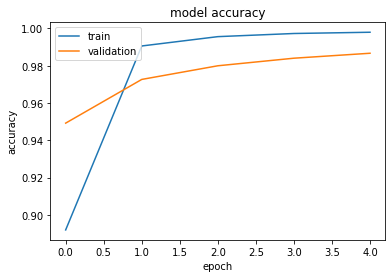

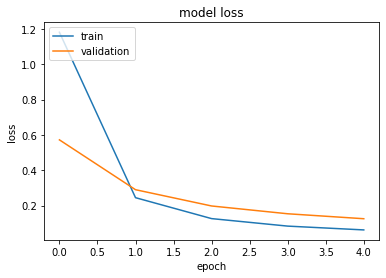

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()